# Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее вреить тестирование

# Цель

Предсказать вероятность покупки в течение 90 дней

# Задачи

- Изучить данные

- Разработать полезные признаки

- Создать модель для классификации пользователей

- Улучшить модель и максимизировать метрику roc_auc

- Выполнить тестирование

In [1]:
!pip install phik -q

In [2]:
!pip install shap -q

In [3]:
!pip install catboost -q

In [101]:
!pip install optuna -q

In [108]:
!pip install optuna-integration -q

In [109]:
from sklearn import tree
from sklearn.tree import plot_tree
import warnings 
import pandas as pd
import re
import optuna
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import phik
import shap
import os
from datetime import datetime, timedelta
from collections import Counter

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from optuna import distributions
from optuna.integration import OptunaSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report)

RANDOM_STATE = 42

## 1. Загрузка данных

In [5]:
apparel_messages = pd.read_csv(os.path.join('Desktop', 'мастерская2', 'apparel-messages.csv'))
apparel_purchases = pd.read_csv(os.path.join('Desktop', 'мастерская2', 'apparel-purchases.csv'))
target = pd.read_csv(os.path.join('Desktop', 'мастерская2', 'apparel-target_binary.csv'))
full_campaign_daily_event = pd.read_csv(os.path.join('Desktop', 'мастерская2', 'full_campaign_daily_event.csv'))
full_campaign_daily_event_channel = pd.read_csv(os.path.join('Desktop', 'мастерская2', 'full_campaign_daily_event_channel.csv'))

pd.set_option('display.float_format', '{:,.2f}'.format)

In [6]:
apparel_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [7]:
apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [8]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [9]:
full_campaign_daily_event.head()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [10]:
full_campaign_daily_event_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Все файлы соответствуют стандартам оформления данных

In [11]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Столбцы date и created_at приведу к формату datetime

In [12]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Столбец date приведу к формату datetime

In [13]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Здесь с типами данных всё ок

In [14]:
full_campaign_daily_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

Столбец date приведу к формату datetime

In [15]:
full_campaign_daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

Столбец date приведу к формату datetime

In [16]:
apparel_messages['date'] = pd.to_datetime(apparel_messages['date'], format='%Y-%m-%d')
apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'], format='%Y-%m-%d %H:%M:%S')
apparel_purchases['date'] = pd.to_datetime(apparel_purchases['date'], format='%Y-%m-%d')
full_campaign_daily_event['date'] = pd.to_datetime(full_campaign_daily_event['date'], format='%Y-%m-%d')
full_campaign_daily_event_channel['date'] = pd.to_datetime(full_campaign_daily_event_channel['date'], format='%Y-%m-%d')

Типы данных успешно изменены на необходимые

## 2. Предобработка данных

Проверю наличие пропущенных значений и дубликатов в датафреймах

In [17]:
apparel_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [18]:
apparel_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [19]:
target.isna().sum()

client_id    0
target       0
dtype: int64

In [20]:
full_campaign_daily_event.isna().sum()

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

In [21]:
full_campaign_daily_event_channel.isna().sum()

date                               0
bulk_campaign_id                   0
count_click_email                  0
count_click_mobile_push            0
count_open_email                   0
count_open_mobile_push             0
count_purchase_email               0
count_purchase_mobile_push         0
count_soft_bounce_email            0
count_subscribe_email              0
count_unsubscribe_email            0
nunique_click_email                0
nunique_click_mobile_push          0
nunique_open_email                 0
nunique_open_mobile_push           0
nunique_purchase_email             0
nunique_purchase_mobile_push       0
nunique_soft_bounce_email          0
nunique_subscribe_email            0
nunique_unsubscribe_email          0
count_hard_bounce_mobile_push      0
count_send_mobile_push             0
nunique_hard_bounce_mobile_push    0
nunique_send_mobile_push           0
count_hard_bounce_email            0
count_hbq_spam_email               0
count_send_email                   0
n

Отлично! Пропуски во всех датафреймах отсутствуют

Проверю дубликаты в данных

In [22]:
apparel_purchases.duplicated().sum()

73020

In [23]:
apparel_messages.duplicated().sum()

48610

In [24]:
target.duplicated().sum()

0

In [25]:
full_campaign_daily_event.duplicated().sum()

0

In [26]:
full_campaign_daily_event_channel.duplicated().sum()

0

Явные дубликаты присутствуют в: apparel_purchases - 73020, apparel_messages - 48610

Приняла решение избавиться от явных дубликатов, так как в датафрейме есть только дата, но нет времени

In [27]:
apparel_purchases = apparel_purchases.drop_duplicates()

In [28]:
apparel_purchases.duplicated().sum()

0

In [29]:
apparel_messages = apparel_messages.drop_duplicates()

In [30]:
apparel_messages.duplicated().sum()

0

# apparel_purchases

In [31]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129188 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     129188 non-null  int64         
 1   quantity      129188 non-null  int64         
 2   price         129188 non-null  float64       
 3   category_ids  129188 non-null  object        
 4   date          129188 non-null  datetime64[ns]
 5   message_id    129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.9+ MB


In [32]:
apparel_purchases['category_ids'].nunique()

933

In [33]:
apparel_purchases['category_ids'].value_counts(ascending=True).head(30)

category_ids
['4', '28', '44', '528']            1
['5562', '5632', '5603', '1095']    1
['5963', '5959', '6021', '999']     1
['4', '29', '314', '1579']          1
['5562', '5558', '5618', '878']     1
['5562', '5589', '5623', '1775']    1
['6060', '6057', '6074', '1211']    1
['4', '5837', '6013', '863']        1
['5562', '5597', '5540', '916']     1
['5562', '5632', '5552', '1089']    1
['4', '27', '205', '1081']          1
['1', '8', '280', '710']            1
['4', '28', '239', '6202']          1
['4', '27', '278', '644']           1
['5562', '5632', '5639', '1629']    1
['5562', '5599', '5539', '5950']    1
['4', '5837', '5836', '839']        1
['5562', '5597', '5696', '1429']    1
['4', '27', '350', '1589']          1
['4', '1822', '1824', '1615']       1
['4', '27', '278', '471']           1
['5562', '5597', '5642', '1218']    1
['5562', '5589', '5613', '1727']    1
['4', '28', '44', '1593']           1
['4', '5837', '5838', '5835']       1
['4', '44', '1600']                 1

Удалю лишние символы

In [34]:
def remove(s):
    return re.sub('[^0-9]+', ' ', s)

apparel_purchases['category_ids'] = apparel_purchases['category_ids'].apply(remove)

Также заменю пробелы на заглушку -9

In [35]:
apparel_purchases.loc[apparel_purchases['category_ids'] == ' ', 'category_ids'] = -9

In [36]:
apparel_purchases['category_ids'].nunique()

932

# apparel_messages

In [37]:
apparel_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [38]:
apparel_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Неявные дубликаты отсутствуют

# количественные значения в таблицах

In [39]:
apparel_purchases.drop(['client_id'], axis=1).describe()

,quantity,price,date
count,"129,188.00","129,188.00",129188
mean,1.01,"1,264.53",2023-02-26 07:40:09.771805440
min,1.00,1.00,2022-05-16 00:00:00
25%,1.00,399.00,2022-09-09 00:00:00
50%,1.00,999.00,2023-03-22 00:00:00
75%,1.00,"1,750.00",2023-06-28 00:00:00
max,30.00,"85,499.00",2024-02-16 00:00:00
std,0.22,"1,375.02",NaN


Явные выбросы и аномалии в количественных значениях отсутствуют.

# Исследовательский анализ данных

In [40]:
def quantitative(data, col, bins=20):
    # Вывод описательной статистики
    print(data[col].describe())
    # Создание фигуры и осей для графиков
    fig, axes = plt.subplots(nrows=1, ncols=2)
    # Гистограмма
    axes[0].hist(data[col], bins=bins, edgecolor='black')
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel(col)
    # Диаграмма размаха
    axes[1].boxplot(data[col], vert=False)
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_xlabel(col)
    axes[1].set_yticklabels([])
    # Настройка внешнего вида графиков
    plt.tight_layout()
    plt.show()

In [41]:
def categorical(data, cat):
    # Подсчет количества наблюдений для каждой категории
    counts = data[cat].value_counts()
    # Создание диаграммы
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.barplot(x=counts.index, y=counts.values, ax=ax, order=counts.index)
    # Добавление меток с количеством наблюдений
    for i, v in enumerate(counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    # Настройка подписей осей и заголовка
    ax.set_xlabel('Категории')
    ax.set_ylabel('Частота встречаемости')
    ax.set_title(f'Распределение категорий признака {cat}')
    # Отображение диаграммы
    plt.show()

In [42]:
def categorical_top(data, cat):
    # Фильтруем данные, исключая значения -9
    filtered_data = data[data[cat] != -9]
    # Строим гистограмму
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.countplot(x=cat, data=filtered_data, order=filtered_data[cat].value_counts(ascending=False).head(10).index, ax=ax)
    # Добавляем подписи с абсолютными значениями
    for patch in ax.patches:
        ax.annotate(f'{patch.get_height()}', (patch.get_x() + patch.get_width() / 2., patch.get_height()), ha='center', va='bottom')
    # Устанавливаем заголовок и метки осей
    ax.set_title(f'Распределение категорий признака {cat}')
    ax.set_xlabel('Категории')
    ax.set_ylabel('Частота встречаемости')
    # Выводим график
    plt.show()

**Исследовательский анализ apparel_purchases**

count   129,188.00
mean          1.01
std           0.22
min           1.00
25%           1.00
50%           1.00
75%           1.00
max          30.00
Name: quantity, dtype: float64


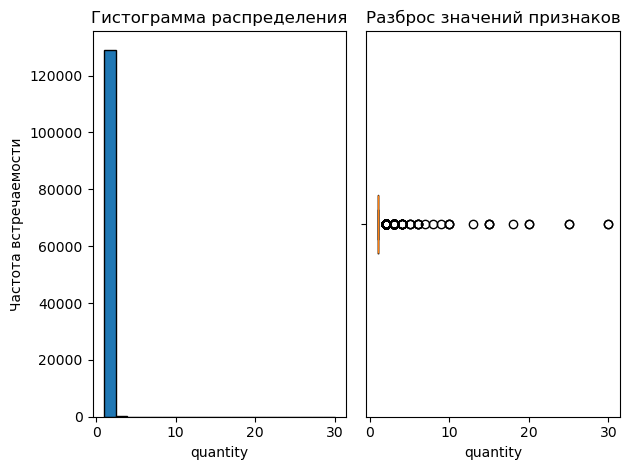

In [43]:
quantitative(apparel_purchases, 'quantity')

В основном покупки совершали - 1. Максимально - 30

count   129,188.00
mean      1,264.53
std       1,375.02
min           1.00
25%         399.00
50%         999.00
75%       1,750.00
max      85,499.00
Name: price, dtype: float64


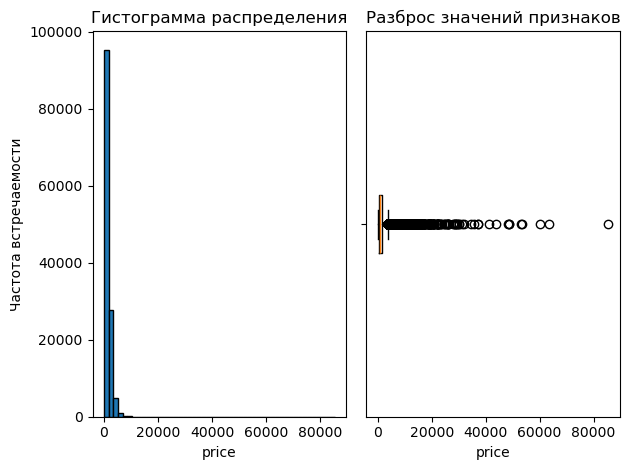

In [44]:
quantitative(apparel_purchases, 'price', bins=50)

Суммы заказов в основном небольшие (до 10.000), можно удалить выбросы, которые составляют выше этой суммы

In [45]:
apparel_purchases['price'] = apparel_purchases['price'].clip(upper=10000)

count   129,188.00
mean      1,250.78
std       1,166.59
min           1.00
25%         399.00
50%         999.00
75%       1,750.00
max      10,000.00
Name: price, dtype: float64


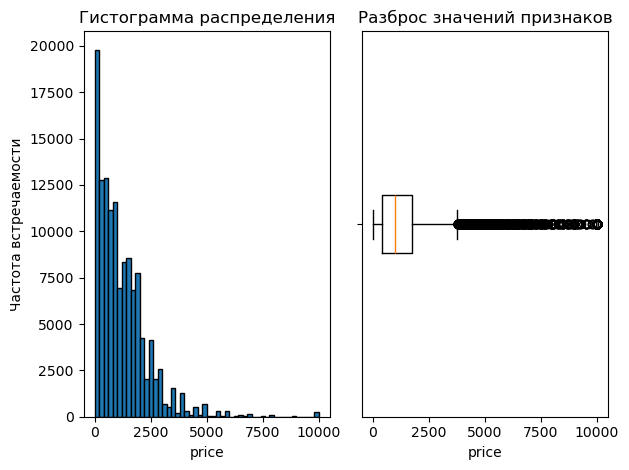

In [46]:
quantitative(apparel_purchases, 'price', bins=50)

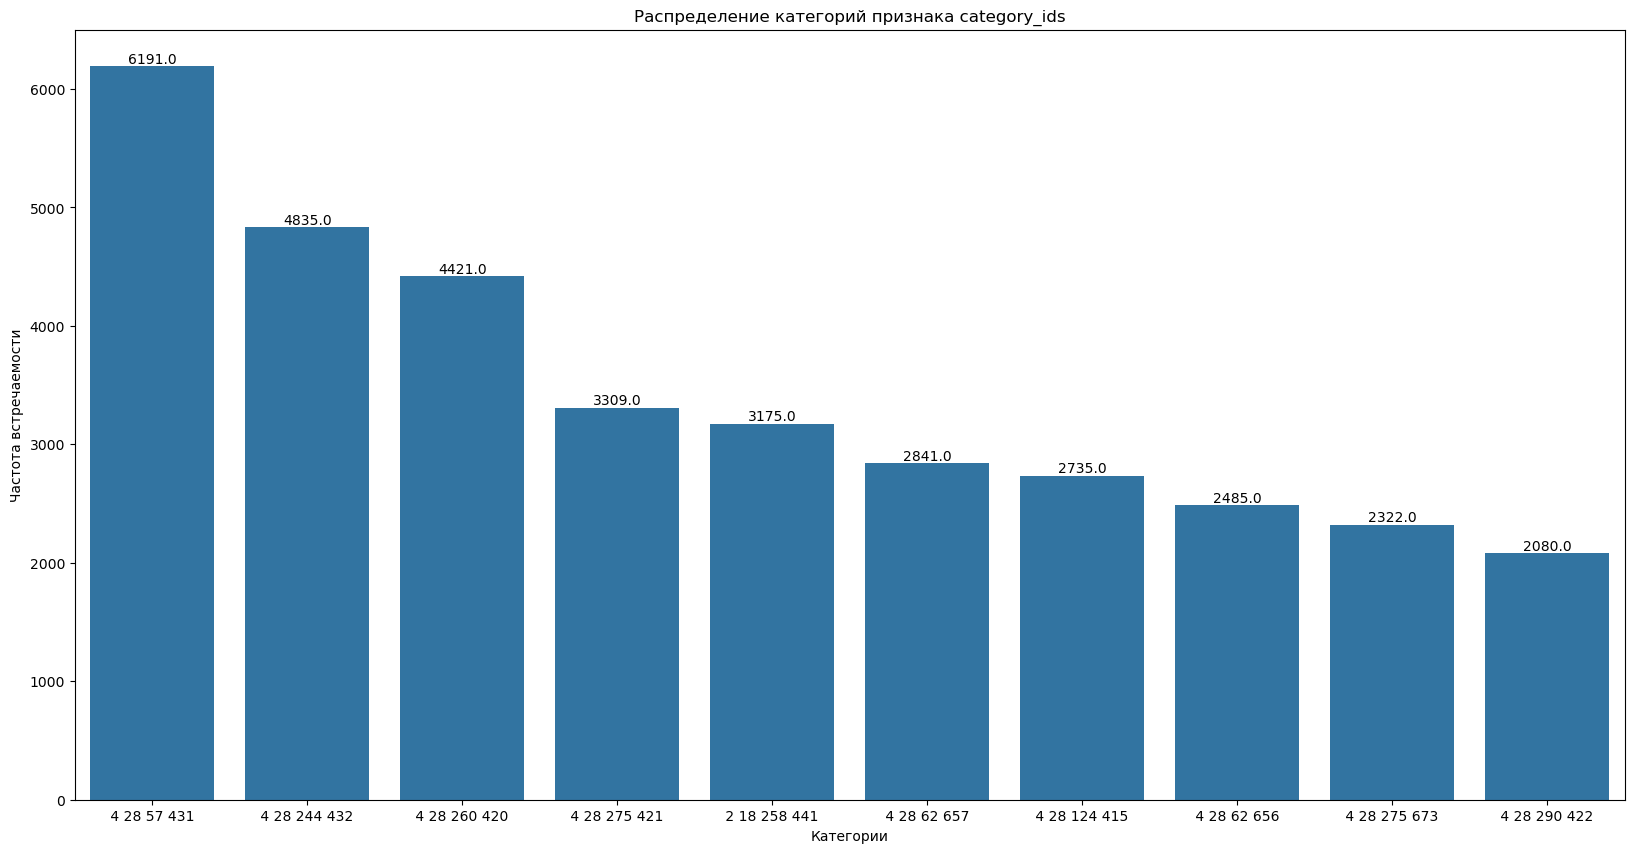

In [47]:
categorical_top(apparel_purchases, 'category_ids')

Почти все из топ-10 категорий входят: 4, 28

**Исследовательский анализ apparel_messages**

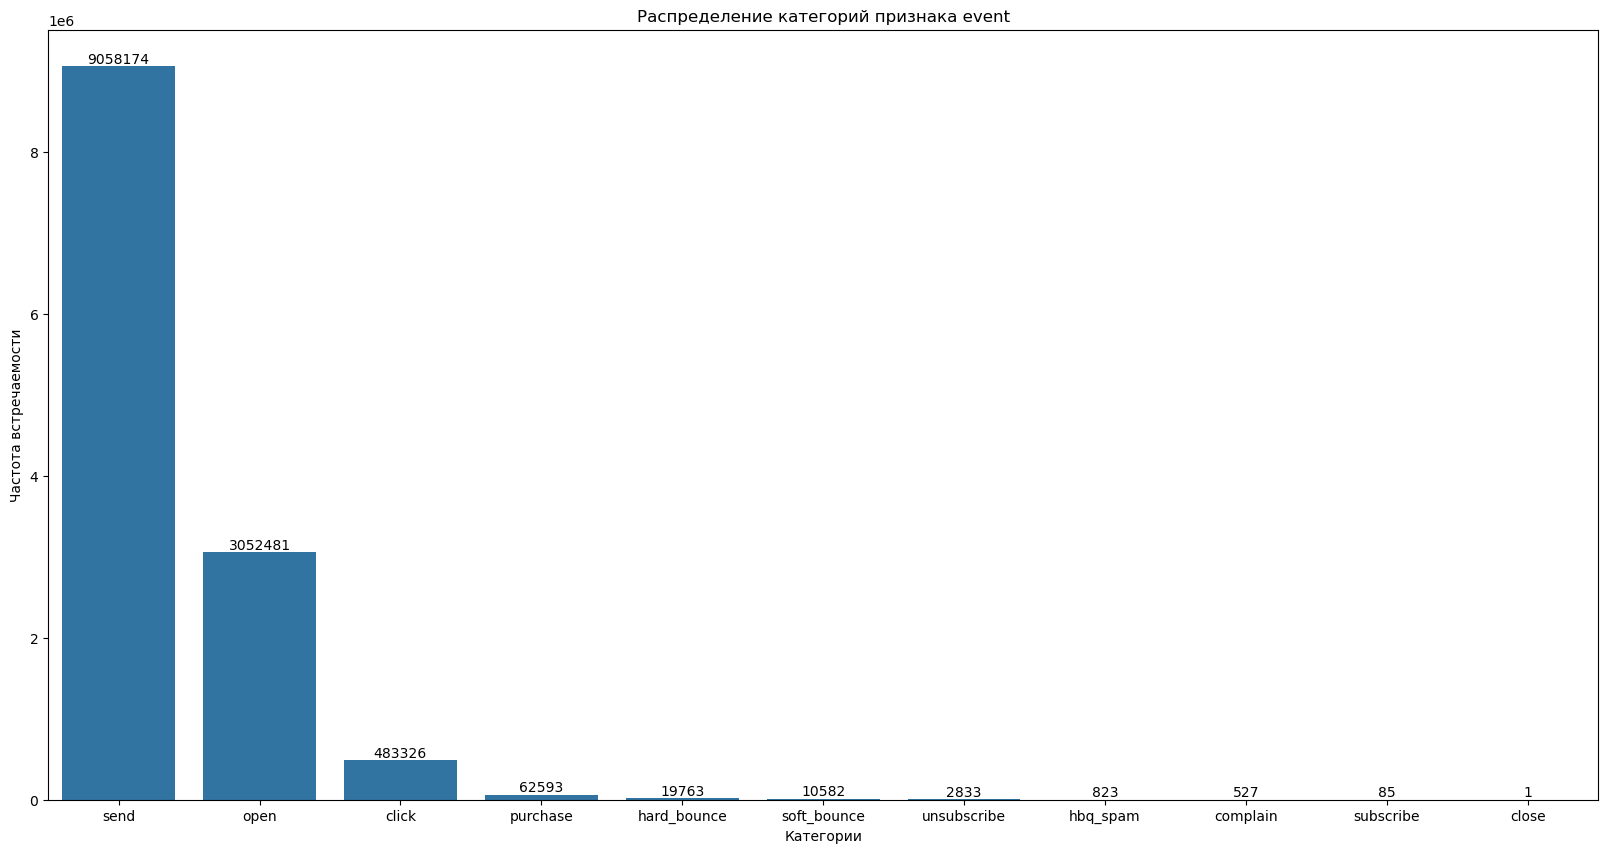

In [48]:
categorical(apparel_messages, 'event')

Здесь можно будет сделать следующие категории: положительную (открыли, нажали, совершили покупку), нейтральную (просто отправили), отрицательную (все оставшиеся категории).

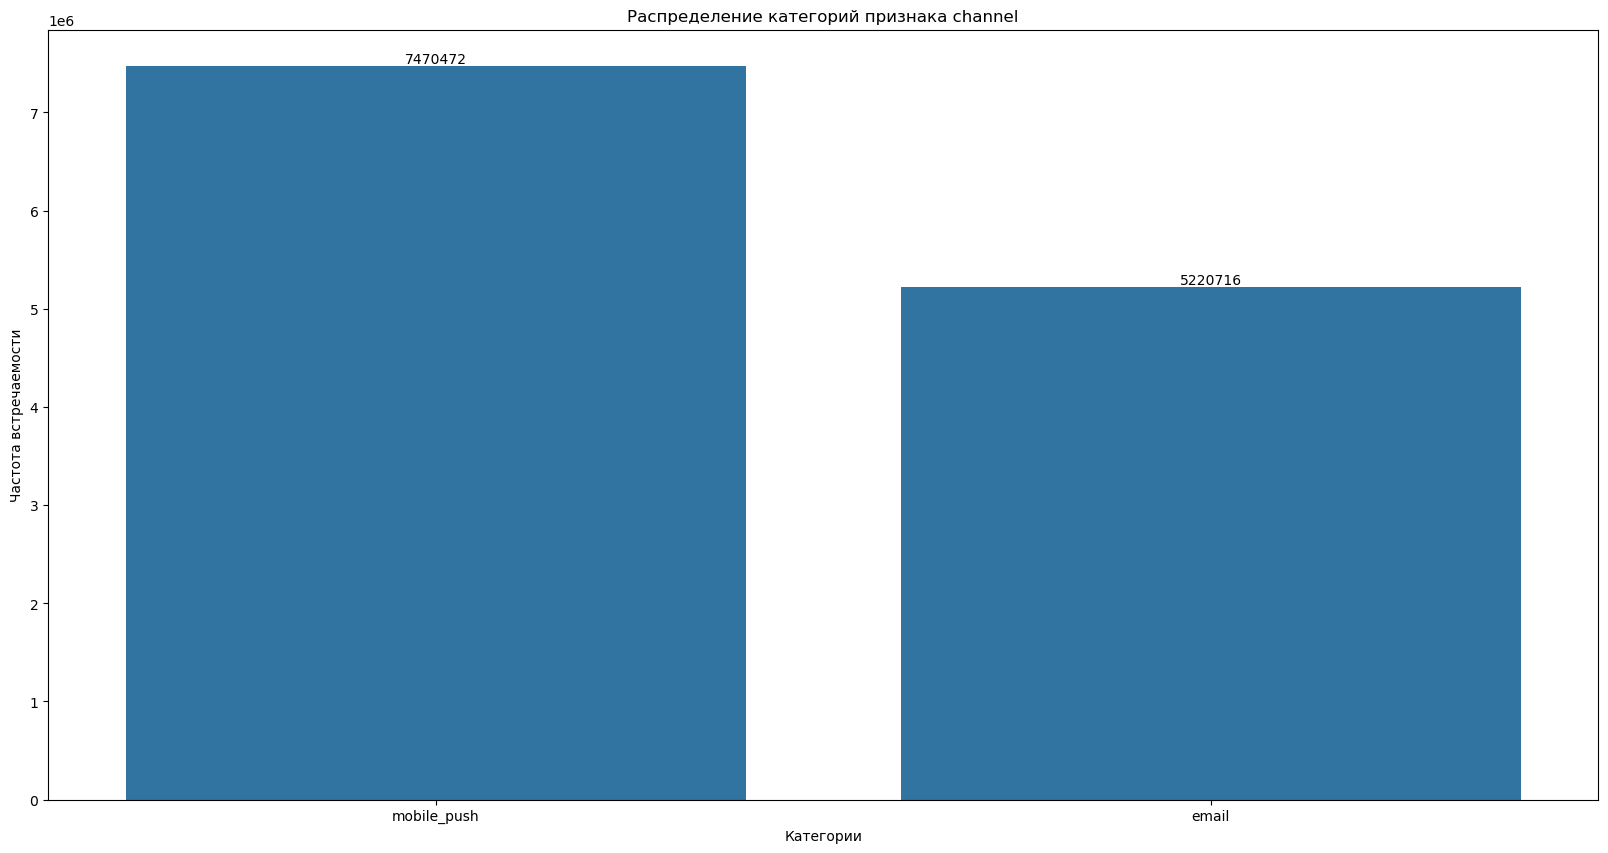

In [49]:
categorical(apparel_messages, 'channel')

Почти в 2 раза чаще письма открываются при помощи пуш-уведомлений.

**Исследовательский анализ target**

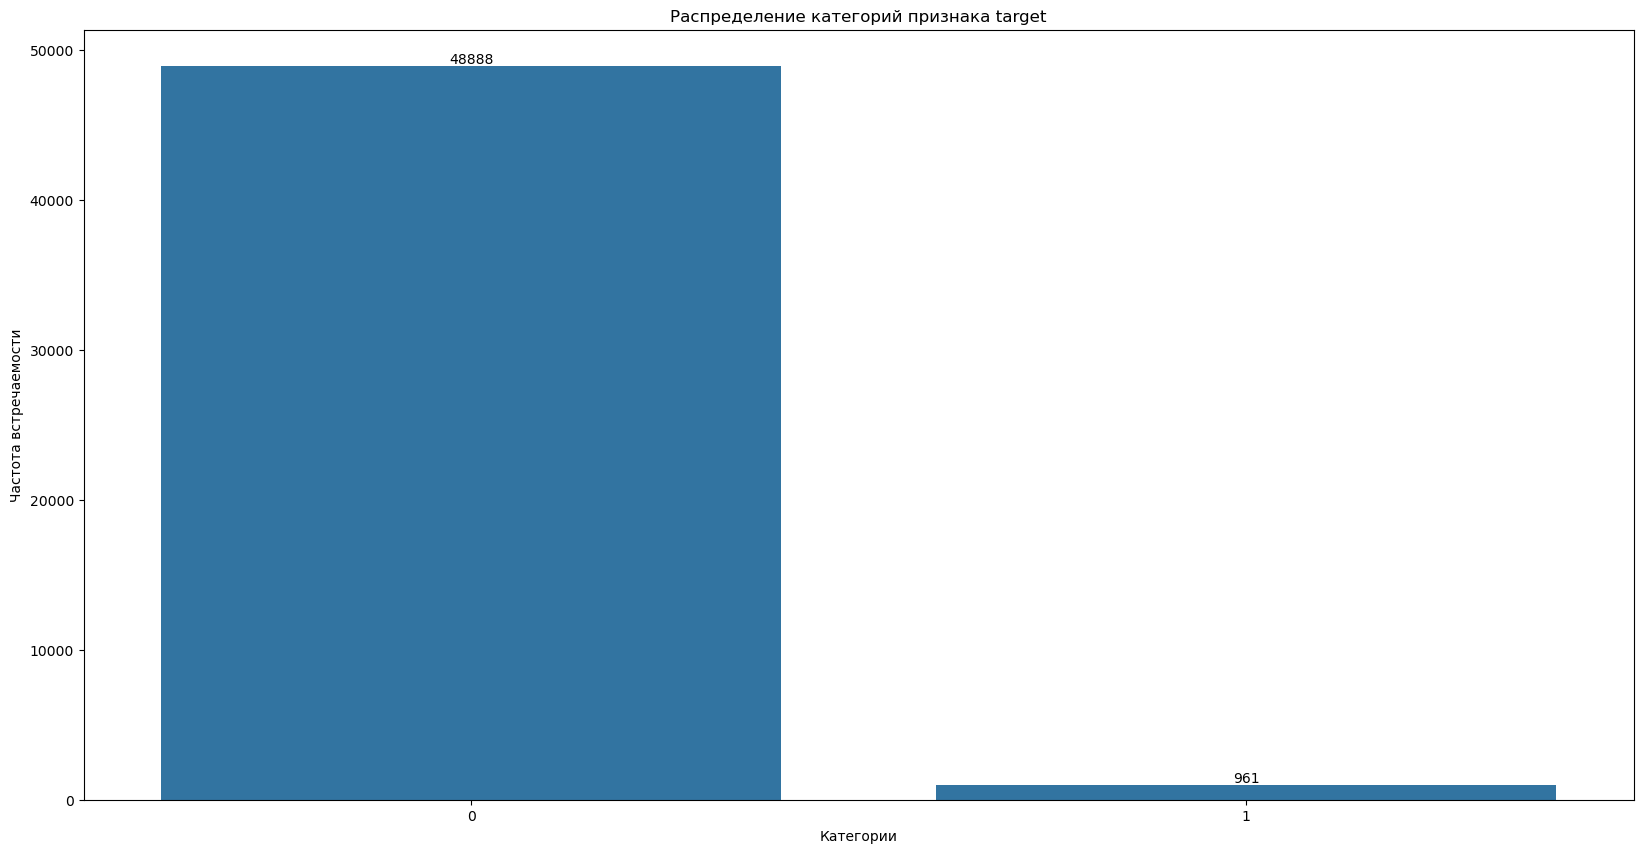

In [50]:
categorical(target, 'target')

Заметен дисбаланс классов.

# Создание новых признаков

In [51]:
target.shape

(49849, 2)

In [52]:
apparel_messages_per_client = apparel_messages.groupby('client_id')['message_id'].count().reset_index(name='messages_sent')
df = target.merge(apparel_messages_per_client, on='client_id', how='left')

df.head(5)

,client_id,target,messages_sent
0,1515915625468060902,0,177.00
1,1515915625468061003,1,165.00
2,1515915625468061099,0,276.00
3,1515915625468061100,0,428.00
4,1515915625468061170,0,293.00


In [53]:
df['messages_sent'] = df['messages_sent'].fillna(df['messages_sent'].median())

df.isna().sum()

client_id        0
target           0
messages_sent    0
dtype: int64

In [54]:
apparel_quantity_total = apparel_purchases.groupby('client_id')['quantity'].sum().rename('quantity_total').reset_index()
df = df.merge(apparel_quantity_total, on='client_id', how='left')

df.head(5)

,client_id,target,messages_sent,quantity_total
0,1515915625468060902,0,177.00,5
1,1515915625468061003,1,165.00,6
2,1515915625468061099,0,276.00,1
3,1515915625468061100,0,428.00,1
4,1515915625468061170,0,293.00,8


In [55]:
df.isna().sum()

client_id         0
target            0
messages_sent     0
quantity_total    0
dtype: int64

In [56]:
apparel_total_spent = apparel_purchases.groupby('client_id')['price'].sum().rename('total_spent').reset_index()
df = df.merge(apparel_total_spent, on='client_id', how='left')

df.head(5)

,client_id,target,messages_sent,quantity_total,total_spent
0,1515915625468060902,0,177.00,5,"4,795.00"
1,1515915625468061003,1,165.00,6,"14,135.00"
2,1515915625468061099,0,276.00,1,299.00
3,1515915625468061100,0,428.00,1,"1,049.00"
4,1515915625468061170,0,293.00,8,"14,102.00"


In [57]:
df.isna().sum()

client_id         0
target            0
messages_sent     0
quantity_total    0
total_spent       0
dtype: int64

In [58]:
apparel_purchases_sorted = apparel_purchases[['client_id','date']].sort_values(['client_id','date'])
apparel_purchases_sorted.head(5)

,client_id,date
3695,1515915625468060902,2022-05-27
3696,1515915625468060902,2022-05-27
3697,1515915625468060902,2022-05-27
3700,1515915625468060902,2022-05-27
3701,1515915625468060902,2022-05-27


In [59]:
apparel_purchases_sorted['days_between_purchases'] = apparel_purchases_sorted.groupby('client_id')['date'].diff().dt.days
apparel_purchases_sorted.head(5)

,client_id,date,days_between_purchases
3695,1515915625468060902,2022-05-27,NaN
3696,1515915625468060902,2022-05-27,0.00
3697,1515915625468060902,2022-05-27,0.00
3700,1515915625468060902,2022-05-27,0.00
3701,1515915625468060902,2022-05-27,0.00


In [60]:
avg_days_between_purchases = apparel_purchases_sorted.groupby('client_id')['days_between_purchases'] \
                                                 .mean().reset_index(name='avg_days_between_purchases')

avg_days_between_purchases['avg_days_between_purchases'] = avg_days_between_purchases['avg_days_between_purchases'] \
                                                                                              .fillna(0)
avg_days_between_purchases.isna().sum()

client_id                     0
avg_days_between_purchases    0
dtype: int64

In [61]:
df = df.merge(avg_days_between_purchases, on='client_id', how='left')

df.head(5)

,client_id,target,messages_sent,quantity_total,total_spent,avg_days_between_purchases
0,1515915625468060902,0,177.00,5,"4,795.00",0.00
1,1515915625468061003,1,165.00,6,"14,135.00",0.00
2,1515915625468061099,0,276.00,1,299.00,0.00
3,1515915625468061100,0,428.00,1,"1,049.00",0.00
4,1515915625468061170,0,293.00,8,"14,102.00",11.86


In [62]:
df.isna().sum()

client_id                     0
target                        0
messages_sent                 0
quantity_total                0
total_spent                   0
avg_days_between_purchases    0
dtype: int64

In [63]:
apparel_last_purchase_date = apparel_purchases.groupby('client_id')['date'].max().rename('last_purchase_date')
df = df.merge(apparel_last_purchase_date, on='client_id', how='left')

df.head(5)

,client_id,target,messages_sent,quantity_total,total_spent,avg_days_between_purchases,last_purchase_date
0,1515915625468060902,0,177.00,5,"4,795.00",0.00,2022-05-27
1,1515915625468061003,1,165.00,6,"14,135.00",0.00,2023-01-04
2,1515915625468061099,0,276.00,1,299.00,0.00,2022-05-17
3,1515915625468061100,0,428.00,1,"1,049.00",0.00,2024-02-10
4,1515915625468061170,0,293.00,8,"14,102.00",11.86,2023-06-17


In [64]:
df['days_since_last_purchase'] = (apparel_purchases['date'].max() - df['last_purchase_date']).dt.days

df.head(5)

,client_id,target,messages_sent,quantity_total,total_spent,avg_days_between_purchases,last_purchase_date,days_since_last_purchase
0,1515915625468060902,0,177.00,5,"4,795.00",0.00,2022-05-27,630
1,1515915625468061003,1,165.00,6,"14,135.00",0.00,2023-01-04,408
2,1515915625468061099,0,276.00,1,299.00,0.00,2022-05-17,640
3,1515915625468061100,0,428.00,1,"1,049.00",0.00,2024-02-10,6
4,1515915625468061170,0,293.00,8,"14,102.00",11.86,2023-06-17,244


In [65]:
df = df.drop('last_purchase_date', axis=1)

In [66]:
df.isna().sum()

client_id                     0
target                        0
messages_sent                 0
quantity_total                0
total_spent                   0
avg_days_between_purchases    0
days_since_last_purchase      0
dtype: int64

In [67]:
df['category_event'] = \
apparel_messages['event']\
.apply(lambda x: 'good' if x in ['open',
                                 'click',
                                 'purchase',
                                 'subscribe'] else ('bad' if x in ['unsubscribe',
                                                                   'complain'] else 'neutral'))

     

In [68]:
df

,client_id,target,messages_sent,quantity_total,total_spent,avg_days_between_purchases,days_since_last_purchase,category_event
0,1515915625468060902,0,177.00,5,"4,795.00",0.00,630,good
1,1515915625468061003,1,165.00,6,"14,135.00",0.00,408,good
2,1515915625468061099,0,276.00,1,299.00,0.00,640,good
3,1515915625468061100,0,428.00,1,"1,049.00",0.00,6,good
4,1515915625468061170,0,293.00,8,"14,102.00",11.86,244,good
...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,3.00,1,"1,499.00",0.00,0,neutral
49845,1515915626010266132,0,233.00,1,909.00,0.00,2,good
49846,1515915626010439406,0,233.00,1,99.00,0.00,0,neutral
49847,1515915626010443527,0,233.00,1,"1,999.00",0.00,0,neutral


Закодирую category_event с помощью OrdinalEncoder

In [73]:
encoder = OrdinalEncoder() 
encoded_data = encoder.fit_transform(df[['category_event']])
encoded_df = pd.DataFrame(encoded_data, columns=['category_event_encoded'])
df = pd.concat([df, encoded_df], axis=1)

In [75]:
df.head(5)

,client_id,target,messages_sent,quantity_total,total_spent,avg_days_between_purchases,days_since_last_purchase,category_event,category_event_encoded
0,1515915625468060902,0,177.00,5,"4,795.00",0.00,630,good,1.00
1,1515915625468061003,1,165.00,6,"14,135.00",0.00,408,good,1.00
2,1515915625468061099,0,276.00,1,299.00,0.00,640,good,1.00
3,1515915625468061100,0,428.00,1,"1,049.00",0.00,6,good,1.00
4,1515915625468061170,0,293.00,8,"14,102.00",11.86,244,good,1.00


In [78]:
del df['category_event']

In [79]:
df.head(3)

,client_id,target,messages_sent,quantity_total,total_spent,avg_days_between_purchases,days_since_last_purchase,category_event_encoded
0,1515915625468060902,0,177.00,5,"4,795.00",0.00,630,1.00
1,1515915625468061003,1,165.00,6,"14,135.00",0.00,408,1.00
2,1515915625468061099,0,276.00,1,299.00,0.00,640,1.00


In [80]:
df.isna().sum()

client_id                     0
target                        0
messages_sent                 0
quantity_total                0
total_spent                   0
avg_days_between_purchases    0
days_since_last_purchase      0
category_event_encoded        0
dtype: int64

# Матрица корреляции

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   49849 non-null  int64  
 1   target                      49849 non-null  int64  
 2   messages_sent               49849 non-null  float64
 3   quantity_total              49849 non-null  int64  
 4   total_spent                 49849 non-null  float64
 5   avg_days_between_purchases  49849 non-null  float64
 6   days_since_last_purchase    49849 non-null  int64  
 7   category_event_encoded      49849 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.0 MB


interval columns not set, guessing: ['target', 'messages_sent', 'quantity_total', 'total_spent', 'avg_days_between_purchases', 'days_since_last_purchase', 'category_event_encoded']


<Axes: >

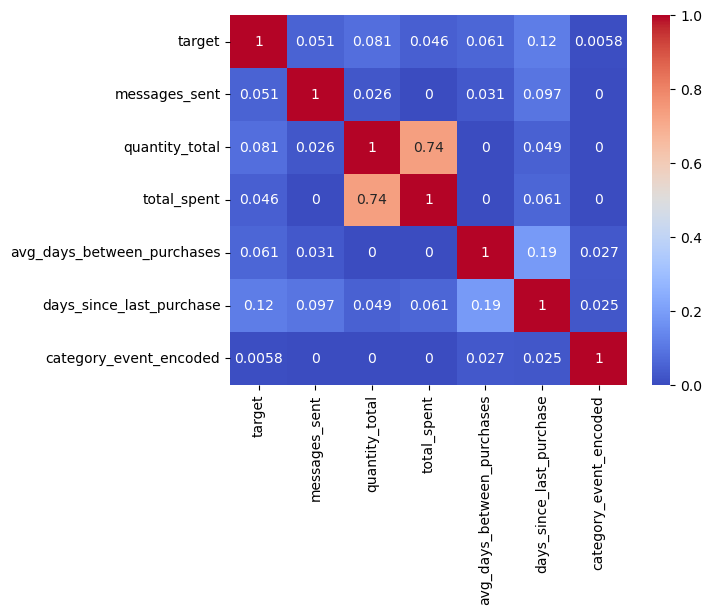

In [82]:
fig, ax = plt.subplots()
sns.heatmap(df.drop(['client_id'], axis=1).phik_matrix(),
            annot=True,
            cmap='coolwarm',
            ax=ax)

Корреляция всех признаков близка к 0.1

# Подготовка данных

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['client_id','target'], axis=1),
    df['target'],
    test_size = 0.25,
    random_state = RANDOM_STATE,
    stratify=df['target']
)

In [89]:
num_columns = ['messages_sent', 
       'quantity_total',
       'total_spent',
       'avg_days_between_purchases',
       'days_since_last_purchase']
ord_columns = ['category_event_encoded']

In [90]:
# добавляем ord кодирование
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

# Лучшая модель

In [91]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 31),
        'models__max_features': range(2, 31),
        'models__min_samples_split': range(1, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler()]
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler()]
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1'
        )],
        'models__C': [0.01, 0.1, 1, 2, 3, 4, 5],
        'preprocessor__num': [StandardScaler()]
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel' : ['rbf', 'sigmoid'],
        'models__C': [0.01, 0.1, 1, 2, 3, 4, 5, 6],
        'models__gamma': [0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler()]
    }
]

In [96]:
rand_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=100
)
rand_search.fit(X_train, y_train);
print('Лучшая модель и её параметры:\n\n', rand_search.best_params_)

Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 1, 'models__max_features': 23, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}


C:\Users\Public\anac\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Public\anac\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Public\anac\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Public\anac\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_

In [117]:
y_pred = rand_search.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC на кросс-валидации:', rand_search.best_score_)
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred))

Метрика ROC-AUC на кросс-валидации: 0.6980265906809766
Метрика ROC-AUC на тестовой выборке: 0.6873996086612671


In [111]:
pipe_final_forest = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE))
])

parameters_forest = {
    'models__max_depth': distributions.IntDistribution(2, 35),
    'models__min_samples_split': distributions.IntDistribution(2, 30),
    'models__max_features': distributions.IntDistribution(1, 20),
    'models__min_samples_leaf': distributions.IntDistribution(1, 20),
}

oscv_forest = OptunaSearchCV(
    pipe_final_forest,
    parameters_forest,
    scoring='roc_auc',
    cv=5,
    n_trials=5,
    random_state=RANDOM_STATE
)
oscv_forest.fit(X_train, y_train);

C:\Users\Ангелина\AppData\Local\Temp\ipykernel_14152\2382191764.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv_forest = OptunaSearchCV(
[I 2024-10-02 19:44:58,807] A new study created in memory with name: no-name-648cc264-6363-412b-9b4c-c86c921ba8b7
[I 2024-10-02 19:45:17,165] Trial 0 finished with value: 0.6985438078951342 and parameters: {'models__max_depth': 17, 'models__min_samples_split': 26, 'models__max_features': 2, 'models__min_samples_leaf': 7}. Best is trial 0 with value: 0.6985438078951342.
[I 2024-10-02 19:45:59,840] Trial 1 finished with value: 0.6762037864312536 and parameters: {'models__max_depth': 18, 'models__min_samples_split': 10, 'models__max_features': 5, 'models__min_samples_leaf': 4}. Best is trial 0 with value: 0.6985438078951342.
[I 2024-10-02 19:46:27,317] Trial 2 finished with value: 0.7137225568769322 and parameters: {'models__max_depth': 7, 'models__min_samples_split': 11,

In [112]:
oscv_forest.best_params_

{'models__max_depth': 7,
 'models__min_samples_split': 11,
 'models__max_features': 7,
 'models__min_samples_leaf': 20}

In [113]:
y_pred_forest = oscv_forest.predict_proba(X_test)[:,1]
print('Метрика ROC-AUC модели на кросс-валидации:', oscv_forest.best_score_)
print('Метрика ROC-AUC модели на тестовой выборке:', roc_auc_score(y_test, y_pred_forest))   

Метрика ROC-AUC модели на кросс-валидации: 0.7137225568769322
Метрика ROC-AUC модели на тестовой выборке: 0.7140251302189861


In [120]:
print('Модель DecisionTreeClassifier:')
print('кросс-валидация:', rand_search.best_score_)
print('тестовая выборка:', roc_auc_score(y_test, y_pred))

print('\nМодель RandomForestClassifier:')
print('кросс-валидация:', oscv_forest.best_score_)
print('тестовая выборка:', roc_auc_score(y_test, y_pred_forest))

Модель DecisionTreeClassifier:
кросс-валидация: 0.6980265906809766
тестовая выборка: 0.6873996086612671

Модель RandomForestClassifier:
кросс-валидация: 0.7137225568769322
тестовая выборка: 0.7140251302189861


# Итоги

Датасеты были предобработаны. Было большое кол-во дубликатов, которые я удалила. Выбросы были удалены. Были созданы следующие признаки: общее кол-во сообщений, число покупок, сумма потраченных средств, средний период покупок, дни с последней покупки. В новый признак вошли значения: good, neutral, bad. Для поиска лучшей модели ииспользовала RandomizedSearchCV, в которой лучшей моделью стала DecisionTreeClassifier (ROC-AUC на кросс-валидации составил 0.69, а на тестовой выборке 0.68. Для поиска лучший параметров модели RandomForestClassifier использовала OptunaSearchCV (ROC-AUC на кросс-валидации составил 0.713, на тестовой выборке 0.714).

# Рекомендации

Стоит обратить внимание, что временной признак является одним из самых важных. Если создать новые временные признаки, качество предсказания может улучшиться.